# Teacher–Student MLP (1 hidden layer) + **SAM** schedule (sharpness control)

This notebook implements a simple **realizable** teacher–student regression problem:

- Inputs: $x \sim \mathcal{N}(0, I)$  
- Labels: $y = f_{\text{teacher}}(x)$ (no noise; realizable)
- Student: same architecture as the teacher

We compare training regimes:

1. **SGD baseline**
2. **SAM** (Sharpness-Aware Minimization): prefers **flat** solutions by minimizing worst-case loss in a neighborhood.


In [164]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Reproducibility
torch.set_num_threads(1)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

print("PyTorch:", torch.__version__)


PyTorch: 2.5.1


In [166]:
class OneHiddenMLP(nn.Module):
    """1-hidden-layer MLP: f(x) = v^T relu(Wx) / sqrt(m)"""
    def __init__(self, d_in: int, d_hidden: int):
        super().__init__()
        self.W = nn.Linear(d_in, d_hidden, bias=False)
        self.v = nn.Linear(d_hidden, 1, bias=False)
        self.d_hidden = d_hidden

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.W(x))
        return self.v(h) / math.sqrt(self.d_hidden)


def init_teacher_student(d_in=20, d_hidden=50, device="cpu"):
    """Teacher is frozen; student is trainable."""
    teacher = OneHiddenMLP(d_in, d_hidden).to(device)
    student = OneHiddenMLP(d_in, d_hidden).to(device)

    with torch.no_grad():
        teacher.W.weight.normal_(0, 1 / math.sqrt(d_in))
        #teacher.v.weight.normal_(0, 1 / math.sqrt(d_hidden))
        teacher.v.weight.fill_(1.0)

        student.W.weight.normal_(0, 1 / math.sqrt(d_in))
        student.v.weight.normal_(0, 1)

    for p in teacher.parameters():
        p.requires_grad_(False)

    return teacher, student


def gen_data(teacher: nn.Module, n=1024, d_in=20, device="cpu"):
    x = torch.randn(n, d_in, device=device)
    with torch.no_grad():
        y = teacher(x) 
        y = y + 0.01 * torch.randn_like(y)
    return x, y


## SAM utilities (first-order)

We implement a lightweight, explicit SAM step for a **single batch**:

1. Compute gradient $g = \nabla_w \mathcal{L}(w)$  
2. Perturb weights: $w \leftarrow w + \rho g / \|g\|$  
3. Compute gradient at perturbed weights: $g_{adv}=\nabla_w \mathcal{L}(w+\epsilon)$  
4. Restore weights and apply update

For **SAM**, we use $g_{adv}$ as the gradient.  
For **Anti-SAM**, we use $(1+\lambda)g - \lambda g_{adv}$.


In [169]:
def _grad_norm(parameters, eps: float = 1e-12) -> torch.Tensor:
    norms = []
    for p in parameters:
        if p.grad is None:
            continue
        norms.append(torch.norm(p.grad.detach()).to(p.device))
    if not norms:
        return torch.tensor(0.0)
    return torch.norm(torch.stack(norms)) + eps


@torch.no_grad()
def _perturb_params(parameters, rho: float, grad_norm: torch.Tensor):
    """Add SAM perturbation; returns list of perturbations to undo."""
    e_ws = []
    for p in parameters:
        if p.grad is None:
            e_ws.append(None)
            continue
        e_w = rho * p.grad / grad_norm
        p.add_(e_w)
        e_ws.append(e_w)
    return e_ws


@torch.no_grad()
def _restore_params(parameters, e_ws):
    for p, e_w in zip(parameters, e_ws):
        if e_w is None:
            continue
        p.sub_(e_w)


def sam_grads(model: nn.Module, xb: torch.Tensor, yb: torch.Tensor, rho: float):
    """Compute (g, g_adv) where g=∇L(w), g_adv=∇L(w+eps*)."""
    params = [p for p in model.parameters() if p.requires_grad]

    # g = ∇L(w)
    model.zero_grad(set_to_none=True)
    loss = F.mse_loss(model(xb), yb)
    loss.backward()
    g = [p.grad.detach().clone() if p.grad is not None else None for p in params]

    # Perturb weights
    grad_norm = _grad_norm(params)
    e_ws = _perturb_params(params, rho=rho, grad_norm=grad_norm)

    # g_adv = ∇L(w+eps)
    model.zero_grad(set_to_none=True)
    loss_adv = F.mse_loss(model(xb), yb)
    loss_adv.backward()
    g_adv = [p.grad.detach().clone() if p.grad is not None else None for p in params]

    # Restore weights
    _restore_params(params, e_ws)

    return loss.detach(), loss_adv.detach(), g, g_adv


## Training loop (SGD / SAM / SAM→Anti-SAM)

We support three modes:

- `mode="sgd"`: vanilla SGD on MSE  
- `mode="sam"`: SAM for all steps  
- `mode="sam_to_antisam"`: SAM up to `switch_step`, then Anti-SAM afterwards

Anti-SAM gradient:
\[
\nabla \widehat{\mathcal{J}}(w) \approx (1+\lambda)g - \lambda g_{adv}.
\]


In [183]:
def train(
    model: nn.Module,
    xtr: torch.Tensor,
    ytr: torch.Tensor,
    xte: torch.Tensor,
    yte: torch.Tensor,
    mode: str = "sgd",
    steps: int = 600,
    batch_size: int = 128,
    lr: float = 0.05,
    rho: float = 0.02,
    lam: float = 0.5,
    switch_step: int = 300,
):
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    n = xtr.size(0)
    hist = {
        "train_loss": [],
        "test_loss": [],
        "loss_adv": [],
        "phase": [],
    }

    params = [p for p in model.parameters() if p.requires_grad]

    for s in range(steps):
        idx = torch.randint(0, n, (batch_size,), device=xtr.device)
        xb, yb = xtr[idx], ytr[idx]

        if mode in ("sam", "sam_to_antisam"):
            base_loss, adv_loss, g, g_adv = sam_grads(model, xb, yb, rho=rho)
            use_antisam = (mode == "sam_to_antisam") and (s >= switch_step)

            for p, gi, gadi in zip(params, g, g_adv):
                if gi is None or gadi is None:
                    p.grad = None
                    continue
                if use_antisam:
                    p.grad = (1 + lam) * gi - lam * gadi
                else:
                    p.grad = gadi  # SAM uses g_adv as update direction

            phase = "anti-SAM" if use_antisam else "SAM"

        else:
            # SGD
            opt.zero_grad(set_to_none=True)
            base_loss = F.mse_loss(model(xb), yb)
            base_loss.backward()
            adv_loss = torch.tensor(float("nan"))
            phase = "SGD"

        opt.step()

        if s % 10 == 0 or s == steps - 1:
            with torch.no_grad():
                idx2 = torch.randint(0, n, (batch_size,), device=xtr.device)
                tr_loss = F.mse_loss(model(xtr[idx2]), ytr[idx2]).item()
                te_loss = F.mse_loss(model(xte[:batch_size]), yte[:batch_size]).item()

            hist["train_loss"].append(tr_loss)
            hist["test_loss"].append(te_loss)
            hist["loss_adv"].append(float(adv_loss) if torch.isfinite(adv_loss) else np.nan)
            hist["phase"].append(phase)

    return hist


## Run an experiment

Suggested safe defaults:

- `rho`: 0.01–0.03  
- `lam`: 0.1–0.7  
- `switch_step`: around half of total steps


In [277]:
device = "cpu"
d_in = 150
d_hidden = 75
n_train = 5*d_in**2
n_test = 1024

teacher, student_sgd  = init_teacher_student(d_in=d_in, d_hidden=d_hidden, device=device)
_,      student_sam   = init_teacher_student(d_in=d_in, d_hidden=d_hidden, device=device)
_,      student_sched = init_teacher_student(d_in=d_in, d_hidden=d_hidden, device=device)

xtr, ytr = gen_data(teacher, n=n_train, d_in=d_in, device=device)
xte, yte = gen_data(teacher, n=n_test,  d_in=d_in, device=device)

steps = 80000

hist_sgd = train(student_sgd, xtr, ytr, xte, yte,
                 mode="sgd", steps=steps, lr=0.01, batch_size=1000)

hist_sam = train(student_sam, xtr, ytr, xte, yte,
                 mode="sam", steps=steps, lr=0.01, rho=0.2, batch_size=1000)

print("Final test MSE (SGD):         ", hist_sgd["test_loss"][-1])
print("Final test MSE (SAM):         ", hist_sam["test_loss"][-1])


Final test MSE (SGD):          0.0019114217720925808
Final test MSE (SAM):          0.007909269072115421
Final test MSE (SAM→Anti-SAM): 408.8855285644531


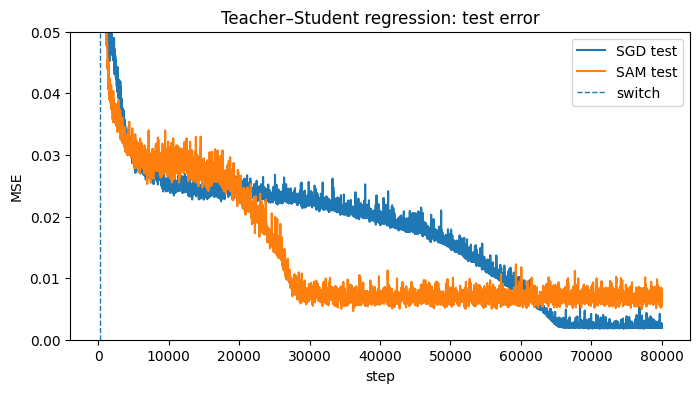

In [281]:
steps_axis = np.arange(len(hist_sgd["test_loss"])) * 10

plt.figure(figsize=(8,4))
plt.plot(steps_axis, hist_sgd["test_loss"], label="SGD test")
plt.plot(steps_axis, hist_sam["test_loss"], label="SAM test")
plt.axvline(300, linestyle="--", linewidth=1, label="switch")
plt.xlabel("step")
plt.ylabel("MSE")
plt.title("Teacher–Student regression: test error")
plt.legend()
plt.ylim(0, 0.05)
plt.show()


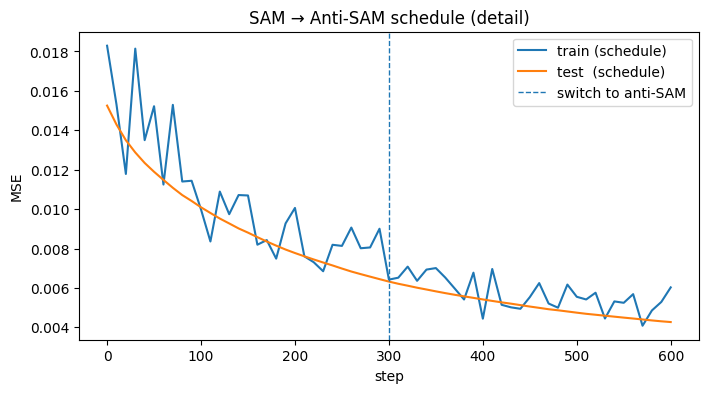

In [14]:
plt.figure(figsize=(8,4))
plt.plot(steps_axis, hist_sched["train_loss"], label="train (schedule)")
plt.plot(steps_axis, hist_sched["test_loss"], label="test  (schedule)")
plt.xlabel("step")
plt.ylabel("MSE")
plt.title("SAM → Anti-SAM schedule (detail)")
plt.legend()
plt.show()


## Notes

- This is a **toy** realizable regression case. All methods can reach very low error.
- The point is to give you a clean scaffold for exploring **flat→sharp** schedules.

Next steps to connect to “universal → specialization” more directly:
- compute teacher–student overlaps (e.g., alignment between student and teacher pre-activations)
- sweep sample size `n_train` and hidden width `d_hidden`
